In [154]:
import scipy
import numpy as np
import data_import
import matplotlib.pyplot as plt

In [155]:

def get_policy(Q, x, b, policy):
    """
    updates policy to the next policy,
    returns error
    """
    err2 = 0
    y = np.dot(Q, x) + b
    for i in range(len(x)):
        choice = 0.0
        if y[i] < x[i]:
            choice = 1
        err2 += min(x[i], y[i]) ** 2    # x should be > 0, while y should be as close to 0 as possible

        policy[i,i] = choice
    flat_policy = [i for i in range(policy.shape[0]) if policy[i,i] == 1]
    return err2 ** 0.5

def update_value(policy, Q, b, use_cg = True):
    """
    returns the next x given the policy
    """
    I = np.eye(len(b))
    A = np.dot(
            np.dot(
                policy,
                Q
            ),
            policy
        ) + I - policy
    rhs = -np.dot(policy, b) 
    lst_sqr_soln = np.linalg.lstsq(A , rhs, 1e-12)[0]
    cg_soln, cg_conv = scipy.sparse.linalg.cg(A , rhs , tol=1e-10
        # , maxiter=len(rhs) * 1e10 # this is default... see https://github.com/scipy/scipy/blob/v1.9.3/scipy/sparse/linalg/_isolve/iterative.py#L298-L385
    )
    if cg_conv != 0:
        print("CG DID NOT CONVERGE!")
    # print(
    #     "cg soln err:",
    #     np.linalg.norm(
    #         np.dot(A, cg_soln) - rhs
    #     )
    # )
    if use_cg:
        return cg_soln
    else:
        return lst_sqr_soln


def flow(Q, N, v0, max_itrs = 100, m_tol = 1e-09, CoR = 1):
    """
    does policy iteration
    returns a bool/vector pair: (converged, x)
    """
    b = np.dot(N.T, (1 + CoR) * v0)
    min_err = 1.0e10
    min_err_x = np.zeros(b.shape[0])
    x = np.zeros(b.shape[0])
    policy = np.zeros((b.shape[0], b.shape[0]))
    error = 0.0

    previous_lambdas = []
    cg_ls_diff = []
    A_det = []
    resid = []

    for n_iter in range(max_itrs):
        # print("n_iter: ", n_iter)
        error = get_policy(Q, x, b, policy)
        if error < min_err:
            min_err = error
            min_err_x = x.copy()
        # print(error)

        if error <= m_tol:
            return (True, x, min_err, min_err_x, -1, cg_ls_diff, A_det, resid)

        x_cg = update_value(policy, Q, b, True)
        x_ls = update_value(policy, Q, b, False)

        cg_ls_diff.append(np.linalg.norm(x_cg - x_ls))

        A = np.dot( np.dot( policy, Q), policy) + np.eye(len(b)) - policy
        rhs = -np.dot(policy, b) 
        A_det.append(np.linalg.det(A))

        resid.append((
            np.linalg.norm(np.dot(A, x_cg) - rhs),
            np.linalg.norm(np.dot(A, x_ls) - rhs)
        ))

        x = x_ls.copy()

        
        if list(x) in previous_lambdas:
            return (False , x, min_err, min_err_x, len(previous_lambdas) - previous_lambdas.index(list(x)), cg_ls_diff, A_det, resid)
        
        previous_lambdas.append(list(x.copy()))
    
    return (False , x, min_err, min_err_x, -1, cg_ls_diff, A_det, resid)  # shouldn't get here


In [156]:
# pd_data = data_import.read_files_to_pd_dataframe(
#     [f"../outs/grid_v2/itr_{i}.xml.out" for i in range(500)]
# )
pd_data = data_import.read_files_to_pd_dataframe(
    [f"../outs/grid/itr_{i}.xml.out" for i in range(500)]
)
# pd_data = data_import.read_file_to_pd_dataframe("../simple_example.out")
# pd_data = data_import.read_file_to_pd_dataframe("../K4.out")

In [157]:
np.set_printoptions(linewidth=2000, precision=10)

# ensure that cg solution yields least sqr soln (inner solver)

In [158]:
cg_ls_diff_t = []
A_det_t = []
resid_t = []
min_err_t = []
cycle_size_t = []
min_err_x_t = []
for i in range(len(pd_data)):
    Q = pd_data['Q'][i]
    N = pd_data['N'][i]
    v0= pd_data['v0'][i]
    converged, x, min_err, min_err_x, cycle_size, cg_ls_diff, A_det, resid = flow(Q, N, v0)
    min_err_x_t.append(min_err_x.copy())
    cg_ls_diff_t += cg_ls_diff.copy()
    A_det_t += A_det.copy()
    resid_t += resid.copy()
    min_err_t.append(min_err)
    cycle_size_t.append(cycle_size)

CG DID NOT CONVERGE!
CG DID NOT CONVERGE!
CG DID NOT CONVERGE!
CG DID NOT CONVERGE!
CG DID NOT CONVERGE!
CG DID NOT CONVERGE!


In [159]:
print(len(cg_ls_diff_t))
print(len(A_det_t))
print(len(resid_t))

5318
5318
5318


In [160]:
diff_soln_counter = 0

for i in range(len(A_det_t)):
    # non singular.... ensure that both cg and lst sqrs soln is the same
    if abs(A_det_t[i]) > 1e-06 and abs(cg_ls_diff_t[i]) > 1e-06:
        print("AHHHHH ", i) # this never prints
    
    # singular.... ensure that cg and lst sqrs is different sometimes
    if abs(A_det_t[i]) <= 1e-06 and abs(cg_ls_diff_t[i]) > 1e-06:
        diff_soln_counter += 1

    # does "quality of lambda" change if we are using cg vs ls?
    if abs(resid_t[i][0] - resid_t[i][1]) > 1e-07:
        print("ASKLJDDASLKJSDAJKLJKL", i, abs(resid_t[i][0] - resid_t[i][1]), A_det_t[i], cg_ls_diff_t[i])

print(diff_soln_counter)

ASKLJDDASLKJSDAJKLJKL 1158 0.5199058841262565 -3.0449074646393275e-87 426357.7229872154
ASKLJDDASLKJSDAJKLJKL 4894 2.0766893572145443e-05 1.7655497112900267e-71 268.0459010596703
845


## takeaways:
- cg = least squares when A is non-singular (expected)
- cg and least squares are sometimes different when A is singular (expected)
    - with probability of difference ~= 16%
- residual norm is different when A singular on very rare occasions (~2/5000 or less than 0.04%)
    - one of the times, difference was very small (O(1e-5))
    - other time difference was fairly large (~0.5)! 
    - both of these times the norm between lst squares soln and cg soln was ~250 and ~400,000 respectively

# does using cg vs cg yield different solution when converges?

In [161]:

def flow_inner_choice(Q, N, v0, initial_guess = np.array([]), max_itrs = 100, m_tol = 1e-09, CoR = 1, use_cg = True):
    """
    does policy iteration
    returns a bool/vector pair: (converged, x)
    """
    b = np.dot(N.T, (1 + CoR) * v0)
    x = np.zeros(b.shape[0])

    if len(initial_guess) > 0:
        x = initial_guess

    policy = np.zeros((b.shape[0], b.shape[0]))
    error = 0.0

    for n_iter in range(max_itrs):
        error = get_policy(Q, x, b, policy)
        if error <= m_tol:
            return (True, x)
        x = update_value(policy, Q, b, use_cg)
    
    return (False, x)

In [162]:
for i in range(len(cycle_size_t)):
    if pd_data['ipopt_converged'][i] == False:
        continue
    if pd_data['policy_converged'][i] == False:
        print(i, min_err_t[i])


95 3.85552819763498e-15
207 2.03513234975361e-06
308 1.969895152404778e-14
391 5.088892257088417e-15


# ipopt actually diverges sometimes...

In [163]:
p_ipopt_converges = len([a for a in pd_data['ipopt_converged'] if a]) / len(pd_data)
p_pi_converges = len([a for a in pd_data['policy_converged'] if a]) / len(pd_data)
print(p_ipopt_converges, p_pi_converges)

0.176 0.838


In [171]:
# or does it...? maybe we are using wrong error function?
def obj_func(Minv, N, v0, sol):
    # assume elastic collision
    return 0.5 * (N @ sol + v0).T @ Minv @ (N @ sol + v0)

def obj_func_prime(Minv, N, v0, sol):
    err = 0
    b = 2 * N.T @ v0
    # print(N.T @ Minv @ N @ sol)
    y = (N.T @ Minv @ N @ sol) + b
    for i in range(len(sol)):
        err += min(sol[i], y[i]) ** 2    # x should be > 0, while y should be as close to 0 as possible
    return err ** 0.5


In [181]:
derivative_at_ipopt_sol_dist_from_0 = np.array([])
ipopt_objs = []
pi_objs = []
ipopt_objs_prime = []
pi_objs_prime = []
for i in range(len(pd_data)):
    pi_min_err = min_err_t[i]

    ipopt_sol = pd_data['ipopt_sol'][i]

    # calculate the ipopt error like how we calculated the error for the policy iteration
    Q = pd_data['Q'][i]
    v0 = pd_data['v0'][i]
    N = pd_data['N'][i]
    Minv = pd_data['Minv'][i]
    b = np.dot(N.T, (1 + 1) * v0)
    # print(np.linalg.norm(N.T @ Minv @ N - Q)) # always < 1e-06
    ipopt_err = 0
    y = np.dot(Q, ipopt_sol) + b
    for j in range(len(ipopt_sol)):
        ipopt_err += min(ipopt_sol[j], y[j]) ** 2    # x should be > 0, while y should be as close to 0 as possible

    ipopt_err **= 0.5

    derivative_at_ipopt_sol_dist_from_0 = np.append(derivative_at_ipopt_sol_dist_from_0, np.linalg.norm(y))

    ipopt_objs.append(obj_func(Minv, N, v0, ipopt_sol))
    pi_objs.append(obj_func(Minv, N, v0, min_err_x_t[i]))
    ipopt_objs_prime.append(obj_func_prime(Minv, N, v0, ipopt_sol))
    pi_objs_prime.append(obj_func_prime(Minv, N, v0, min_err_x_t[i]))

    tol = 1e-6
    # if ipopt_err < tol and pi_min_err < tol:
    #     print("both ok")
    # if ipopt_err < tol and pi_min_err > tol:
    #     print("policy bad with error:", pi_min_err)
    # if ipopt_err > tol and pi_min_err < tol:
    #     print("ipopt bad with error:", ipopt_err)
    # if ipopt_err > tol and pi_min_err > tol:
    #     print(f"both bad, ipopt: {ipopt_err}, pi: {pi_min_err}")

# print(ipopt_objs)
# print(pi_objs)

diverging_cases = [i for i in range(len(pd_data)) if cycle_size_t[i] == 2]
print(diverging_cases)
print(np.array(min_err_t)[diverging_cases])

[75, 93, 96, 153, 162, 168, 181, 290, 339, 353, 357, 405, 452]
[7.6157358321e-07 4.6312535392e-07 7.4489240776e-08 2.0275141677e-07 8.1459987511e-07 2.2250713778e-06 1.0301940647e+01 7.4643774051e-08 1.0693156891e-06 1.5141861041e-06 6.1429509513e-01 1.4154117256e-07 5.4794890014e+00]


Text(0, 0.5, 'objective function @ PI solution')

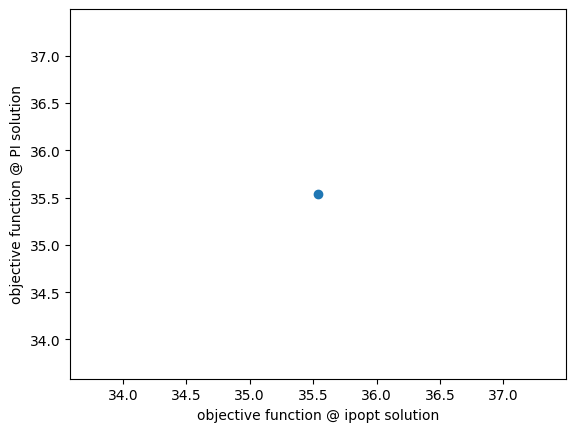

In [ ]:
ipopt_objs = np.array(ipopt_objs)
pi_objs = np.array(pi_objs)
both_converged_filter = [pd_data['policy_converged'][i] and pd_data['ipopt_converged'][i] for i in range(len(pd_data))]

plt.scatter(ipopt_objs[both_converged_filter], pi_objs[both_converged_filter])
plt.xlabel("objective function @ ipopt solution")
plt.ylabel("objective function @ PI solution")

In [ ]:
print(derivative_at_ipopt_sol_dist_from_0)

[2.7370481531e-06]


# Nov 30

What did I do over the week?
- documented the K4 case showing that policy iteration will yield a different solution depending on the initial guess for your policy
    - see `K4_demonstrate_PI_2solns.ipynb`
- then tried to find a simulation where PI would yield different results depending on the inner solver
    - see `pi_diverges_depending_on_inner_solver.ipynb`
    - initially, couldn't find anything interesting, but after setting rcond to be `1e-10 / np.max(A)`, (so anything 1e-10 or less is counted as a 0) gave following results:
        - there were some scenarios where using least squares for inner method didn't converge while cg converged AND VICE VERSA!
        - need to do a little more investigating wrt the `rcond` parameter... why am I only now getting these weird results? Why not when I was using numpy's default settings... TODO
- figured out the stopping criteria for cg & least squares inner solver
    - cg stops at:
        - a) len(b) * 10 iterations, or...
        - b) when it crosses user-specified tolerance (this week I've been using 1e-10) 
    - least squares stops at:
        - whenever it feels like... idk (I should know, we just covered this in MATH235)
        - did research a bit on rcond; this is an argument says "treat an element as 0 if it is less than `np.max(A) * rcond`". This had effects on PI's convergence
    
## big find pt 1:
- upon closely investigating the 9-ball policy iteration diverging, noticed that PI resulted in a policy (control set) that SHOULD have resulted in the IPOPT solution
    - linear solver then didn't find the ipopt solution, instead found a solution that wasn't sufficiently small in error -> cycling ensues

## big find pt 2:
- ipopt solutions don't "converge" according to our policy iteration criteria
    - we try to minimize the derivative (while keeping all lambda >= 0) and stop when the derivative is sufficiently close to 0
    - ipopt stops... ??? idk when, but it's "optimal lambda" is often NOT where the derivative = 0 (most of the time we get output of "ipopt bad with error > 10")
        - see above... norm of derivative evaluated at ipopt's solution is ~ 1-10
    - similarly, the PI solution yields a comparatively large objective function (the QP obj that we are trying to minimize)
        - however, I'm getting that the original objective function evaluated at ipopt's soln is > 0 too... doesn't this mean that dH is large? but when I run simulation it says that dH is ~1e-7
        - leads me to think that I'm doing something wrong in the calculations!



todo: sanity check with a simple case (3 balls)